# Phase 2 Project Notebook -- Jamie Dowat 

#### Project Goals:

* Develop at least 2 variables that are well-modeled with price.
* At least 3 polished visualizations, including a QQ plot

#### Column Definitions
* View:
* Condition
* Grade


## Data Understanding

[Data Source](https://info.kingcounty.gov/assessor/DataDownload/default.aspx)

In [585]:
import pandas as pd
import numpy as np

In [501]:
df = pd.read_csv('../src/kc_house_data.csv')

In [502]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [503]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [504]:
wtrfront_mean = df['waterfront'].mean()

In [505]:
wtrfront_mean

0.007595858696217679

In [471]:
df.waterfront.fillna(wtrfront_mean, inplace=True)

In [506]:
# dropping view and yr_renovated
df.drop(labels=['view', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)

In [507]:
df.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
waterfront       0.276295
floors           0.256804
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
condition        0.036056
long             0.022036
id              -0.016772
zipcode         -0.053402
Name: price, dtype: float64

### Engineering Variables

##### New Column : Price_per_sqft

In [508]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [509]:
df[df['price_per_sqft']==df['price_per_sqft'].max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
19321,6021500970,4/7/2015,874950.0,2,1.0,1080,4000,1.0,0.0,3,7,1080,1940,98117,47.6902,-122.387,1530,4240,810.138889


In [510]:
df[df['price_per_sqft']==df['price_per_sqft'].min()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
18248,2891000610,12/11/2014,148900.0,4,1.75,1700,6000,1.0,0.0,3,7,1700,1967,98002,47.3252,-122.208,1280,6000,87.588235


###### New column : In or out of Seattle

[Source](https://www.usmapguide.com/washington/seattle-zip-code-map/)

In [556]:
seattle_zips = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98110, 98111, 98112, 98114, 98115, 
                98116, 98117, 98118, 98119, 98121, 98122, 98124, 98125, 98126, 98129, 98131, 98132, 98133, 98134,
                98136, 98138, 98144, 98145, 98146, 98148, 98151, 98154, 98155, 98158, 98160, 98161, 98164, 98166,
                98168, 98170, 98171, 98174, 98177, 98178, 98181, 98184, 98185, 98188, 98190, 98191, 98195, 98198,
                98199]

In [566]:
df['in_city'] = np.where(df['zipcode'].isin(seattle_zips), 'Y', 'N')
df['in_city'].value_counts()

N    12624
Y     8973
Name: in_city, dtype: int64

###### New Column: avg price per sqft per ZIPCODE

###### New column : N S E W areas

###### New column : location cost

######  New column : price per LOT sqft

In [567]:
df['price_per_lot_sqft'] = df['price'] / df['sqft_lot']

###### New Column : Month Sold

In [511]:
df.date.dtype

dtype('O')

In [512]:
df['month_sold'] = df['date'].map(lambda x: int(x.split('/')[0]))

In [513]:
df['month_sold'].value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64

###### New Column: SEASON Sold

In [544]:
winter = [12,1,2]
fall = [9,10,11]
summer = [6,7,8]
spring = [3,4,5]

season_vals = []

for month in df['month_sold']:
    if month in winter:
        season_vals.append('winter')
    elif month in fall:
        season_vals.append('fall')
    elif month in summer:
        season_vals.append('summer')
    else:
        season_vals.append('spring')
        
df['season_sold'] = pd.DataFrame(season_vals)
        
df['season_sold'].value_counts()

spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64

##### New Column: Year Sold

In [514]:
df['year_sold'] = df['date'].map(lambda x: int(x.split('/')[2]))
df.year_sold.value_counts()

2014    14622
2015     6975
Name: year_sold, dtype: int64

###### New Column: Decade Built

In [553]:
decades = [(df['yr_built'] >= 1900) & (df['yr_built'] < 1910),
               (df['yr_built'] >= 1910) & (df['yr_built'] < 1920),
               (df['yr_built'] >= 1920) & (df['yr_built'] < 1930),
               (df['yr_built'] >= 1930) & (df['yr_built'] < 1940),
               (df['yr_built'] >= 1940) & (df['yr_built'] < 1950),
               (df['yr_built'] >= 1950) & (df['yr_built'] < 1960),
               (df['yr_built'] >= 1960) & (df['yr_built'] < 1970),
               (df['yr_built'] >= 1970) & (df['yr_built'] < 1980),
               (df['yr_built'] >= 1980) & (df['yr_built'] < 1990),
               (df['yr_built'] >= 1990) & (df['yr_built'] < 2000),
               (df['yr_built'] >= 2000) & (df['yr_built'] < 2010),
               (df['yr_built'] >= 2010) & (df['yr_built'] < 2020)]

decade_names = ['1900_1910', '1910_1920', '1920_1930', '1930_1940', 
                '1940_1950', '1950_1960', '1960_1970', '1970_1980', 
                '1980_1990', '1990_2000', '2000_2010', '2010_2020']

df['decade_built'] = np.select(decades, decade_names, np.nan)

In [555]:
df.decade_built.value_counts()

2000_2010    3515
1960_1970    2658
1950_1960    2450
1970_1980    2285
1980_1990    2281
1990_2000    2232
1940_1950    1763
2010_2020    1241
1920_1930    1192
1910_1920     805
1900_1910     645
1930_1940     530
Name: decade_built, dtype: int64

###### New Column : built within 40 yr block

In [572]:
sections = [decade_names[:4], decade_names[4:8], decade_names[8:]]
sections[0]

['1900_1910', '1910_1920', '1920_1930', '1930_1940']

In [579]:
section_names = []
for section in sections:
    for decade in df['decade_built']:
        if decade in section:
            section_names.append(section[0][:4]+"_"+section[3][5:])
        
df['40yr_section'] = pd.DataFrame(section_names)
df['40yr_section'].value_counts()

1980_2020    9269
1940_1980    9156
1900_1940    3172
Name: 40yr_section, dtype: int64

In [ ]:
###### New Column : built before or after ???

###### New Column: incorporated vs not incorporated

In [580]:
unincorporated_zipcodes = [98019, 98014, 98024, 98065, 98038, 98051, 98022, 98045, 98288, 98224,98051, 98029, 98014, 98077, 98053, 98010, 98070]
df['unincorporated'] = np.where(df['zipcode'].isin(unincorporated_zipcodes), 'Y', 'N')

In [581]:
df['unincorporated'].value_counts()

N    18714
Y     2883
Name: unincorporated, dtype: int64

In [582]:
df_grade_mean = df.groupby('grade').mean()

In [583]:
df_grade_count = df.groupby('grade').count()

In [520]:
df.groupby('grade')['price'].agg([np.mean,np.median])

,mean,median
grade,,
3,2.620000e+05,262000.0
4,2.120019e+05,200000.0
5,2.485240e+05,228700.0
6,3.019166e+05,275276.5
7,4.025946e+05,375000.0
8,5.429868e+05,510000.0
9,7.737382e+05,720000.0
10,1.072347e+06,914327.0
11,1.497792e+06,1280000.0


In [521]:
grade_mean_median = df.groupby('grade')['price_per_sqft'].agg([np.mean,np.median])

In [522]:
df.groupby('grade')['price_per_sqft'].mean().values

array([503.84615385, 342.0123655 , 278.93360926, 270.98989171,
       251.88401441, 258.13953459, 275.83939347, 307.74632471,
       342.47894699, 403.60211783, 483.79669319])

### Visualizing Data 

In [533]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

In [534]:
cols = df.drop(labels=['id', 'zipcode', 'lat', 'long', 'date'], axis=1).columns
new_df = df[cols].corr()
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,price_per_sqft,month_sold,year_sold,unincorporated
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.036056,0.667951,0.605368,0.053953,0.585241,0.082845,0.556056,-0.009928,0.003727,-0.030687
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.026496,0.356563,0.479386,0.155670,0.393406,0.030690,-0.205905,-0.001046,-0.009949,-0.005796
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,-0.126479,0.665838,0.686668,0.507173,0.569884,0.088303,-0.090285,0.007543,-0.026577,0.125488
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,-0.059445,0.762779,0.876448,0.318152,0.756402,0.184342,-0.091167,0.012112,-0.029014,0.109243
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,-0.008830,0.114731,0.184139,0.052946,0.144763,0.718204,-0.034749,-0.002591,0.005628,0.264238


<AxesSubplot:>

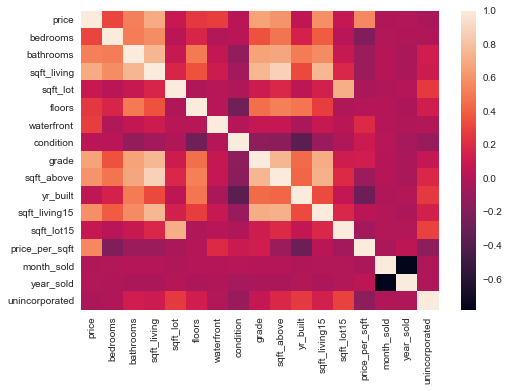

In [535]:
sns.heatmap(new_df)

In [536]:
# Table with highest correlations

best_corrs = new_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
best_corrs['pairs'] = list(zip(best_corrs.level_0, best_corrs.level_1))

# set index to pairs
best_corrs.set_index(['pairs'], inplace = True)

#d rop level columns
best_corrs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
best_corrs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
best_corrs.drop_duplicates(inplace=True)

In [537]:
best_corrs[best_corrs['cc']>.7]

,cc
pairs,
"(price, price)",1.000000
"(sqft_above, sqft_living)",0.973385
"(month_sold, year_sold)",0.971559
"(sqft_living15, sqft_living)",0.948129
"(sqft_above, grade)",0.945619
"(sqft_above, sqft_living15)",0.938104
"(grade, sqft_living15)",0.934954
"(sqft_living, grade)",0.934668
"(bathrooms, sqft_above)",0.934573


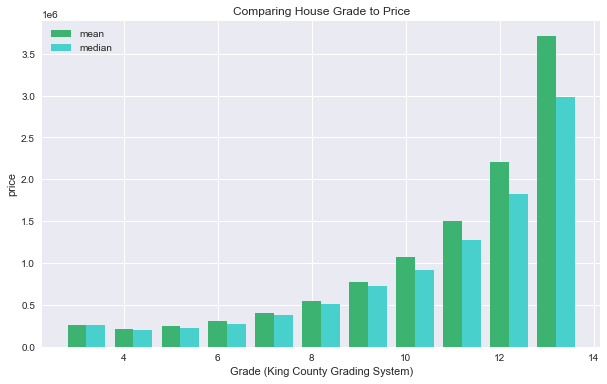

In [538]:
fig, ax = plt.subplots(figsize=(10,6))

grade_means = df.groupby('grade')['price'].mean().values
grade_medians = df.groupby('grade')['price'].median().values

w = 0.4
bar1 = [i for i in range(3,14)]
bar2 = [i+w for i in bar1]

ax.bar(bar1, grade_means, width=w, color='mediumseagreen', label='mean', align='center')
ax.bar(bar2, grade_medians, width=w, color='mediumturquoise', label='median', align='center')

# x and y vals; use bottom parameter to make stacked
ax.set_xlabel('Grade (King County Grading System)')
ax.set_ylabel('price')
ax.set_title('Comparing House Grade to Price')
ax.legend()

<AxesSubplot:xlabel='price', ylabel='Count'>

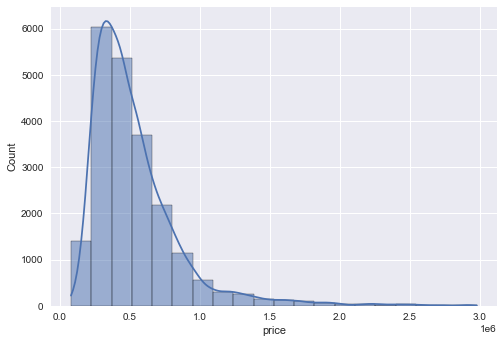

In [539]:
# Distribution of prices
sns.histplot(df['price'][df['price']<3000000], bins=20, kde=True)

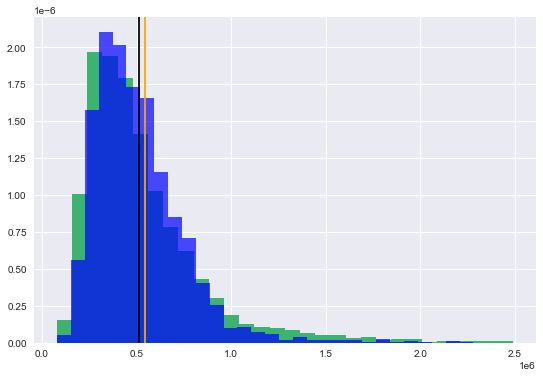

In [540]:
# comparing price distributions for uninc and inc areas
inc = df['price'][(df['unincorporated']==0)&(df['price']<2500000)]
uninc = df['price'][(df['unincorporated']==1)&(df['price']<2500000)]

fig, ax = plt.subplots(figsize=(9,6))

ax.hist(inc, bins=30, color='mediumseagreen', density=True) # inc
ax.hist(uninc, bins=30, color='blue', density=True, alpha=.7) # not inc

ax.axvline(x=df['price'][(df['unincorporated']==0)].mean(), color='orange') # incorporated
ax.axvline(x=df['price'][(df['unincorporated']==1)].mean(), color='black') # not inc

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

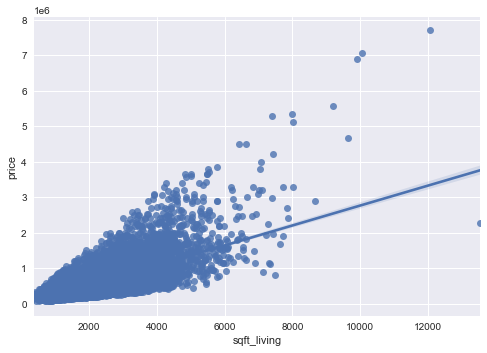

In [586]:
# Distribution of sqft_living and price
sns.regplot(x=df.sqft_living, y=df.price)

###### Distribution of prices - city vs out of city

[Source](https://stackoverflow.com/questions/44552489/plotting-multiple-boxplots-in-seaborn)

In [598]:
in_city = df[['price', 'in_city']][df['in_city']=='Y']
out_of_city = df[['price', 'in_city']][df['in_city']=='N']

cdf = pd.concat([in_city, out_of_city])  
cdf.head()# CONCATENATE
#mdf = pd.melt(cdf, id_vars=['price'], var_name=['in_city']) 
#mdf.head()# MELT

,price,in_city
0,221900.0,Y
1,538000.0,Y
3,604000.0,Y
7,291850.0,Y
8,229500.0,Y


<AxesSubplot:xlabel='in_city', ylabel='price'>

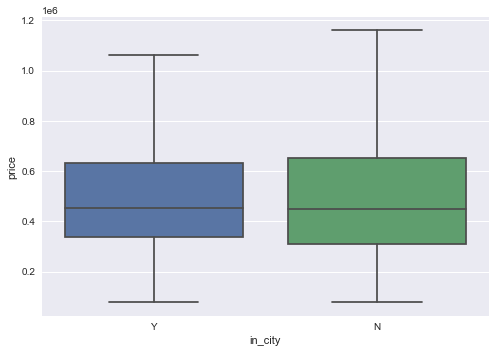

In [600]:
sns.boxplot(x='in_city', y='price', data=cdf, showfliers=False)  # RUN PLOT   

###### Distribution of prices per grade

###### Year built distribution

<AxesSubplot:xlabel='yr_built', ylabel='Count'>

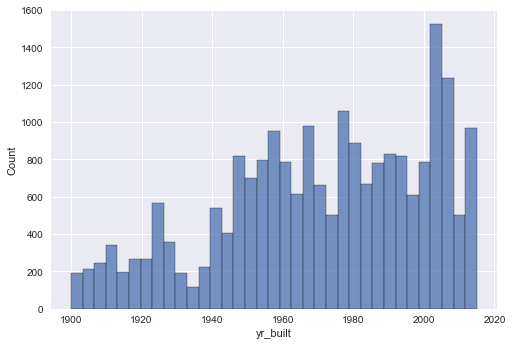

In [552]:
sns.histplot(df.yr_built)

###### Waterfront views? 

In [221]:
df_wf = df
df_wf.dropna(inplace=True, subset=['waterfront'])

In [222]:
df_wf.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                57
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated      3412
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price_per_sqft       0
month_sold           0
unincorporated       0
dtype: int64

In [223]:
df_wf.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [224]:
df_wf['price'][df_wf['waterfront']==1.0].mean()

1717214.7260273972

In [225]:
df_wf['price'][df_wf['waterfront']==0.0].mean()

532641.9866841416

Text(0.5, 1.0, 'Comparing dist of Price per Sqft')

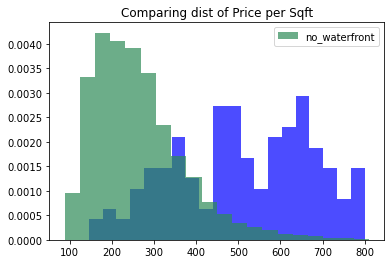

In [354]:
waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==1]
no_waterfront = df_wf['price_per_sqft'][df_wf['waterfront']==0]
plt.hist(waterfront, bins=20, color='blue', density=True, alpha=.7)
plt.hist(no_waterfront, bins=20, color='seagreen', density=True, alpha=.7, label='no_waterfront')
plt.legend()
plt.title('Comparing dist of Price per Sqft')

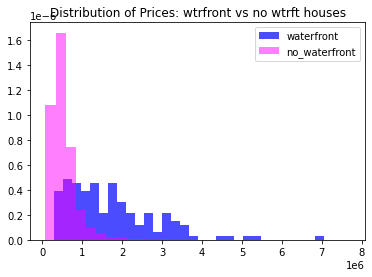

In [230]:
waterfront = df_wf['price'][df_wf['waterfront']==1]
no_waterfront = df_wf['price'][df_wf['waterfront']==0]
plt.hist(waterfront, bins=30, color='blue', density=True, alpha=.7, label='waterfront')
plt.hist(no_waterfront, bins=30, color='magenta', density=True, alpha=.5, label='no_waterfront')
plt.title('Distribution of Prices: wtrfront vs no wtrft houses')
plt.legend()

### PreProcessing Data for Modeling 

In [ ]:
import statsmodels.api as sm

##### DataFrame for Modeling

In [541]:
cols = df.drop(labels=['id', 'zipcode', 'lat', 'long', 'date'], axis=1).columns
mod_df = df[cols]

#### CATEGORICALS

###### bathrooms

In [549]:
bathrooms_series = pd.Series(mod_df['bathrooms'])

cat_bathrooms = bathrooms_series.astype('category')

# Can concat to original data frame
bathrooms = pd.get_dummies(cat_bathrooms, prefix='bath', drop_first=True)

count    21597.000000
mean         2.115826
std          0.768984
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

###### season sold (se)

In [ ]:
season_series = pd.Series(df['season_sold'])

cat_months = months_series.astype('category')

# Can concat to original data frame
months = pd.get_dummies(cat_months, prefix='se', drop_first=True)
months.describe()

###### waterfront (wf) 

In [ ]:
months_series = pd.Series(df['month_sold'])

cat_months = months_series.astype('category')

# Can concat to original data frame
months = pd.get_dummies(cat_months, prefix='mo', drop_first=True)
months.describe()

######  month sold (mo)

In [ ]:
months_series = pd.Series(df['month_sold'])

cat_months = months_series.astype('category')

# Can concat to original data frame
months = pd.get_dummies(cat_months, prefix='mo', drop_first=True)

#### Join categoricals to mod_df

###### Stepwise selection function

In [ ]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

###### Optimizes R-squared value

In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

### MODEL NUMERO UNO

### Model NUMERO DOS - NORMALIZING PRICE ONLY

### MODEL NUMERO TRES - NORMALIZING ALL